# Initialization

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
from importlib import reload
import utils; reload(utils)
from utils import *
from __future__ import division, print_function
path = "data/weather/"
model_path = path + 'models/'

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Model params

- `batch_size` is the training minibatch size: 64-128 seems to work fairly well
- `seq_length` is the number of time samples spread through the previous week to feed into the model for prediction.  32 might be overkill but gives a lot of data for the model to spot patterns on.
- `fp_fn_ratio` is the relative cost of a false negative over a false postive.  That is, if set to `10`, then *not* turning on the sprinklers when there is a frost is considered to be 10x as bad as turning on the sprinklers when there is no frost.

In [3]:
batch_size=4
seq_length=32
fp_fn_ratio=10

# Historic Data

## Actuals from Wunderground

We read in the raw historic data from the CSV file that we pulled from Wunderground using https://github.com/CienegaOrchards/weather-download

The timestamps in there are UTC, but we care about local time, so adjust for that.
Some rows are duplicated in the CSV for some reason; so trim those.  There's also some entries where the data is corrupted, so remove those too.

Then, what we want to try and predict is whether or not the temperature will drop below some threshold within the next 10 hours.  So we do a rolling window looking forward 10 hours and figure out what the minimum temperature will be in that time.  Pandas doesn't do rolling windows forward, so we do a rolling window backwards and then shift that by 10 hours.

Once we have the rolling look-forward minimums, we also figure out the day-of-year (which the model can use to infer seasonal weather patterns), and hour-of-day (so the model can figure out daily patterns).

We then construct a field called `threshold` which tracks whether the look-ahead temp crosses some threshold temp.  We can have a model that tries to forecast *which* threshold we cross by introducing multiple thresholds here, or just have a single threshold.  Then we one-hot that threshold field.

In [4]:
data = pd.read_csv(path + 'wunderground-data.csv', index_col='DateUTC', parse_dates=['DateUTC'],
                   usecols=['DateUTC','TemperatureF','DewpointF','PressureIn',
                            'WindDirection','WindSpeedMPH','WindSpeedGustMPH','Humidity','HourlyPrecipIn',
                            'dailyrainin','SolarRadiationWatts/m^2'],
                  dtype={'WindDirection': 'category'})
data.index = data.index.tz_localize('UTC', ambiguous='infer').tz_convert('US/Pacific')
data.drop_duplicates(inplace=True)

data = data[data.TemperatureF > 0] # Remove bad temp
data = data[data.PressureIn   > 0] # Remove bad pressure
data = data[data.HourlyPrecipIn >= 0] # Remove bad rainfall

data = data.resample('15Min').nearest()

data = data.assign(forward_min = data.rolling('24h', closed='both').TemperatureF.min().shift(-1,'24h').asof(data.index))

# Add some categorical date elements for day-of-year, hour, month -- we'll create embeddings for those in the model
data = data.assign(month = data.index.month, week = data.index.week, hour = data.index.hour)
data.month = data.month.astype('category')
data.week = data.week.astype('category')
data.hour = data.hour.astype('category')

## Historic forecasts as recorded in Dynamo weather_log table

In [5]:
forecasts = pd.read_csv(path+'forecast-min.csv', parse_dates=['time'], index_col='time', usecols=['time','forecast'], dtype={'forecast': 'float'})
forecasts = forecasts.tz_localize('UTC', ambiguous='infer').tz_convert('US/Pacific')

data = data.assign(forecast = forecasts.asof(data.index)).dropna()

data.index = data.index.tz_convert('US/Pacific') # Adjust timezone after date-shifting above to avoid ambiguity which arises when not in UTC

data.head()

,TemperatureF,DewpointF,PressureIn,WindDirection,WindSpeedMPH,WindSpeedGustMPH,Humidity,HourlyPrecipIn,dailyrainin,SolarRadiationWatts/m^2,forward_min,month,week,hour,forecast
DateUTC,,,,,,,,,,,,,,,
2016-02-28 17:45:00-08:00,60.3,49.6,30.13,South,0.0,0.0,68,0.0,0.0,1.43,38.8,2,8,17,58.0
2016-02-28 18:00:00-08:00,59.4,51.1,30.14,SSW,0.0,0.0,74,0.0,0.0,0.00,38.8,2,8,18,58.0
2016-02-28 18:15:00-08:00,57.6,50.7,30.13,SSW,0.0,0.0,78,0.0,0.0,0.00,38.8,2,8,18,56.0
2016-02-28 18:30:00-08:00,56.3,51.6,30.13,SSW,0.0,0.0,84,0.0,0.0,0.00,38.8,2,8,18,56.0
2016-02-28 18:45:00-08:00,54.5,49.1,30.14,SSW,0.0,0.0,82,0.0,0.0,0.00,38.8,2,8,18,56.0


## Build the data sequences

Now we actually build the data sequences.  It takes a LONG time to run this; welcome to Python... I haven't been able to come up with a good way to get Pandas to do this more efficiently than having the (single-threaded!) loop in Python and calling many times over and over into Pandas native code.  There's possibly some clever way of using Pandas to handle the iteration though by using multiple resamples or shifts or something.  For now, we just run the calculation once then save the resulting data frame so that we can just re-load it and not have to repeat the iteration.  The iteration will need to be re-done though any time the sequence length is changed, or if the time slicing exponential thingie is changed above, or of course for new source data.  The `all_y` is very fast though, so we can adjust what we're trying to predict with no big penalty -- that doesn't need to be saved/loaded.

In [6]:
continuous_cols = data[['TemperatureF','DewpointF','PressureIn','WindSpeedMPH','WindSpeedGustMPH',
                    'Humidity','HourlyPrecipIn','dailyrainin','SolarRadiationWatts/m^2','forecast']]
categorical_cols = data[['WindDirection','month','week','hour']] # We'll be attaching embeddings to these

In [7]:
for column in categorical_cols.columns:
    categorical_cols[column] = categorical_cols[column].cat.codes
categorical_cols.head()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,WindDirection,month,week,hour
DateUTC,,,,
2016-02-28 17:45:00-08:00,12,1,7,17
2016-02-28 18:00:00-08:00,10,1,7,18
2016-02-28 18:15:00-08:00,10,1,7,18
2016-02-28 18:30:00-08:00,10,1,7,18
2016-02-28 18:45:00-08:00,10,1,7,18


In [8]:
continuous_x = continuous_cols.as_matrix()
categorical_x = categorical_cols.as_matrix()

# https://books.google.com/books?id=2cxHAQAAMAAJ&lpg=PA146&ots=vqGgxQr1Q_&dq=freezing%20walnut%20blossoms&pg=PA146#v=onepage&q=freezing%20walnut%20blossoms&f=false
# ^ suggests that 31 is probably a good threshold to worry about, so we'll try and predict if we're going to fall below that.

all_y = (data.forward_min<31).as_matrix().reshape(-1,1)

continuous_x.shape, categorical_x.shape, all_y.shape, all_y.mean()*100

((79745, 10), (79745, 4), (79745, 1), 7.036177816791021)

## Split into Train/Validation

We split the data into train & test data sets.  We'll train on the first half of the data and validate on the more recent half.  We ensure that each of train and test set are exact multiple of the sequence length, truncating any extra data; padding will lead to problems because the padding data will try and get modelled and reduce accuracy

In [9]:
val_start = ((len(continuous_x) * 1 // 2) // seq_length) * seq_length
val_end = (len(continuous_x)//seq_length) * seq_length

In [10]:
train_cont_x, train_cat_x, train_y = continuous_x[:val_start], categorical_x[:val_start], all_y[:val_start]
val_cont_x, val_cat_x, val_y = continuous_x[val_start:val_end], categorical_x[val_start:val_end], all_y[val_start:val_end]

train_data = data.iloc[:val_start]
validation_data = data.iloc[val_start:val_end]

train_cont_x.shape, train_cat_x.shape, train_y.shape, val_cont_x.shape, val_cat_x.shape, val_y.shape, train_y.mean(), val_y.mean()

((39872, 10),
 (39872, 4),
 (39872, 1),
 (39872, 10),
 (39872, 4),
 (39872, 1),
 0.07193017656500802,
 0.06879514446227929)

## Create the sequences.

Linear sequences are OK, but not super helpful, as we really want to see longer-term patterns.  LSTM will help with this, but we might be able to kick it up a notch by sampling the time sequence non-linearly, going back in time with fibonacci stepsize, or exponential growth in the index. eg if we have 6 steps, we would predict `[n+1]` using `[n],[n-1],[n-2],[n-3],[n-5],[n-8]` or `[n],[n-1],[n-2],[n-4],[n-8],[n-16]`; we can play with which of those works better.

In [11]:
train_cont_in = np.stack([[train_cont_x[seq_start + i] for i in range(seq_length)] for seq_start in range(0, len(train_cont_x), seq_length)])
train_cat_in = np.stack([[train_cat_x[seq_start + i] for i in range(seq_length)] for seq_start in range(0, len(train_cat_x), seq_length)])
train_cat_out = np.stack([[train_y[seq_start + i] for i in range(seq_length)] for seq_start in range(0, len(train_y), seq_length)])

# Weights: give more emphasis to the ones where the forecast is below threshold
train_sample_weights = ((train_data.forward_min<31).as_matrix() * (fp_fn_ratio-1)+1).reshape(-1,seq_length)

train_cont_in.shape, train_cat_in.shape, train_cat_out.shape,train_sample_weights.shape

((1246, 32, 10), (1246, 32, 4), (1246, 32, 1), (1246, 32))

In [12]:
val_cont_in = np.stack([[val_cont_x[i+j-1] for i in range(seq_length)] for j in range(0, len(val_cont_x), seq_length)])
val_cat_in = np.stack([[val_cat_x[i+j-1] for i in range(seq_length)] for j in range(0, len(val_cat_x), seq_length)])
val_cat_out = np.stack([[val_y[i+j-1] for i in range(seq_length)] for j in range(0, len(val_y), seq_length)])

# Weights: give more emphasis to the ones where the forecast is below threshold
val_sample_weights = ((validation_data.forward_min<31).as_matrix() * (fp_fn_ratio-1)+1).reshape(-1,seq_length)

val_cont_in.shape, val_cat_in.shape, val_cat_out.shape, val_sample_weights.shape

((1246, 32, 10), (1246, 32, 4), (1246, 32, 1), (1246, 32))

In [13]:
train_inputs = [train_cont_in]
val_inputs = [val_cont_in]
for i in range(categorical_x.shape[1]):
    train_inputs.append(train_cat_in[:,:,i].reshape(-1,seq_length,1))
    val_inputs.append(val_cat_in[:,:,i].reshape(-1,seq_length,1))

# The Model

We're going to loop through the categoricals and assign an embedding to each, then concatenate those embeddings with all the continuous inputs, and then feed that whole thing into an LSTM

In [14]:
continuous_inputs=Input(shape=(seq_length,continuous_x.shape[1],), name='Continuous_inputs')
inputs=[continuous_inputs]

model=continuous_inputs

embedding_layers=[continuous_inputs]

for i in range(categorical_x.shape[1]):
    num_values = len(np.unique(categorical_x[:,i]))
    embed_size = math.ceil(math.log(num_values))
    if embed_size > 50:
        embed_size = 50
    input_layer = Input(shape=(seq_length,1,), name=categorical_cols.columns[i] + '_code_input')
    inputs.append(input_layer)
    embedding_layer = Embedding(input_dim=num_values, output_dim=embed_size, input_length=seq_length, name=categorical_cols.columns[i] + '_embedding')(input_layer)
    reshape = Reshape((seq_length,embed_size,), name=categorical_cols.columns[i] + '_reshape')(embedding_layer)
    embedding_layers.append(reshape)

model=Concatenate(name='Merge_inputs')(embedding_layers)
model=BatchNormalization()(model)

model=Dropout(0.9)(model)
model=Conv1D(filters=128, kernel_size=3, dilation_rate=1, padding='causal')(model)
model=keras.layers.advanced_activations.PReLU()(model)

model=Conv1D(filters=64, kernel_size=3, dilation_rate=2, padding='causal')(model)
model=keras.layers.advanced_activations.PReLU()(model)

model=BatchNormalization()(model)

model=Dropout(0.5)(model)

model=TimeDistributed(Dense(1, activation='sigmoid'), name='Output')(model)

model=Model(inputs=inputs,outputs=model)
model.compile(Nadam(), 'binary_crossentropy', sample_weight_mode='temporal')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
WindDirection_code_input (Input (None, 32, 1)        0                                            
__________________________________________________________________________________________________
month_code_input (InputLayer)   (None, 32, 1)        0                                            
__________________________________________________________________________________________________
week_code_input (InputLayer)    (None, 32, 1)        0                                            
__________________________________________________________________________________________________
hour_code_input (InputLayer)    (None, 32, 1)        0                                            
__________________________________________________________________________________________________
WindDirect

# Training run

The callback function here will plot a short graph every few epochs to give an indication of how many, and how severe are the false positives & false negatives predicted by the model against the validation data.  Peaks are times where the forward temperature *did* drop below the threshold but the model did not predict so; valleys are where the model predicts a threshold break but the weather did not actually get that cold.

I also have a callback to automatically lower the learning rate when progress stalls.

Train on 1246 samples, validate on 1246 samples
Epoch 1/20
 - 6s - loss: 1.0124 - val_loss: 0.4802
Epoch 2/20
 - 4s - loss: 0.7223 - val_loss: 0.3869
Epoch 3/20
 - 4s - loss: 0.6445 - val_loss: 0.3860
Epoch 4/20
 - 4s - loss: 0.5952 - val_loss: 0.3560
Epoch 5/20
 - 4s - loss: 0.5768 - val_loss: 0.2796
Epoch 6/20
 - 4s - loss: 0.6235 - val_loss: 0.2634
Epoch 7/20
 - 4s - loss: 0.5403 - val_loss: 0.2289
Epoch 8/20
 - 4s - loss: 0.5729 - val_loss: 0.2440
Epoch 9/20
 - 4s - loss: 0.5562 - val_loss: 0.2436
Epoch 10/20
 - 4s - loss: 0.5266 - val_loss: 0.2297

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.


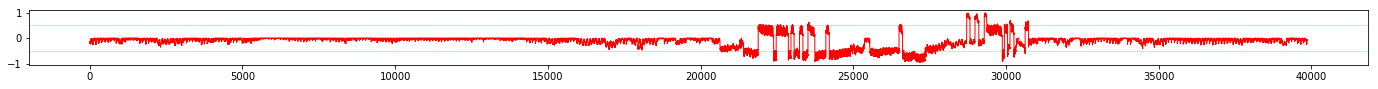

Epoch 11/20
 - 4s - loss: 0.4893 - val_loss: 0.1960
Epoch 12/20
 - 4s - loss: 0.5640 - val_loss: 0.1966
Epoch 13/20
 - 4s - loss: 0.4344 - val_loss: 0.1880
Epoch 14/20
 - 4s - loss: 0.4375 - val_loss: 0.2162
Epoch 15/20
 - 4s - loss: 0.4728 - val_loss: 0.1713
Epoch 16/20
 - 4s - loss: 0.4623 - val_loss: 0.1879
Epoch 17/20
 - 4s - loss: 0.4602 - val_loss: 0.1843
Epoch 18/20
 - 4s - loss: 0.4369 - val_loss: 0.1686
Epoch 19/20
 - 4s - loss: 0.3989 - val_loss: 0.1824
Epoch 20/20
 - 4s - loss: 0.4568 - val_loss: 0.1851


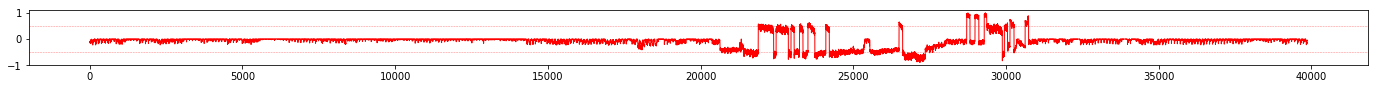

In [15]:
class GraphCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch%10==9:
            plt.figure(figsize=(24,1))
            plt.plot((val_cat_out-model.predict(val_inputs)).reshape(-1,1), 'r', lw=1)
            plt.axhline(0.5, color='r', ls='dashed', lw=0.5, alpha=0.5)
            plt.axhline(-0.5, color='r', ls='dashed', lw=0.5, alpha=0.5)
            plt.show()
graph_cb = GraphCallback()

reduce_lr = ReduceLROnPlateau(factor=0.3, patience=3, verbose=1)

history = model.fit(train_inputs, train_cat_out,
          epochs=20,
          batch_size=batch_size,
          verbose=2,
          validation_data=(val_inputs, val_cat_out),
          sample_weight=train_sample_weights,
          callbacks=[reduce_lr, graph_cb])

Now create pseudo-labels for the validation data and add that to the training set

In [16]:
val_pseudo_out = model.predict(val_inputs)

combo_in = [
            np.concatenate((train_inputs[0], val_inputs[0])),
            np.concatenate((train_inputs[1], val_inputs[1])),
            np.concatenate((train_inputs[2], val_inputs[2])),
            np.concatenate((train_inputs[3], val_inputs[3])),
            np.concatenate((train_inputs[4], val_inputs[4]))
]

combo_out = np.concatenate((train_cat_out, val_pseudo_out))

combo_sample_weights = np.concatenate((train_sample_weights, val_sample_weights))

Go again with the pseudo-labels

Train on 2492 samples, validate on 1246 samples
Epoch 1/20
 - 7s - loss: 0.6498 - val_loss: 0.1787
Epoch 2/20
 - 7s - loss: 0.6307 - val_loss: 0.1657
Epoch 3/20
 - 7s - loss: 0.6354 - val_loss: 0.1780
Epoch 4/20
 - 7s - loss: 0.6419 - val_loss: 0.1710
Epoch 5/20
 - 7s - loss: 0.6241 - val_loss: 0.1657

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00018000000854954124.
Epoch 6/20
 - 7s - loss: 0.6167 - val_loss: 0.1756
Epoch 7/20
 - 7s - loss: 0.6241 - val_loss: 0.1715
Epoch 8/20
 - 7s - loss: 0.5954 - val_loss: 0.1662

Epoch 00008: ReduceLROnPlateau reducing learning rate to 5.400000081863254e-05.
Epoch 9/20
 - 7s - loss: 0.6081 - val_loss: 0.1673
Epoch 10/20
 - 7s - loss: 0.6045 - val_loss: 0.1680


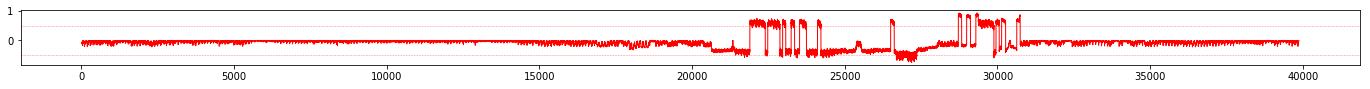

Epoch 11/20
 - 7s - loss: 0.5947 - val_loss: 0.1712

Epoch 00011: ReduceLROnPlateau reducing learning rate to 1.6200000027311033e-05.
Epoch 12/20
 - 7s - loss: 0.6132 - val_loss: 0.1649
Epoch 13/20
 - 7s - loss: 0.5846 - val_loss: 0.1667
Epoch 14/20
 - 7s - loss: 0.6219 - val_loss: 0.1659
Epoch 15/20
 - 7s - loss: 0.6273 - val_loss: 0.1705

Epoch 00015: ReduceLROnPlateau reducing learning rate to 4.859999899053946e-06.
Epoch 16/20
 - 7s - loss: 0.6029 - val_loss: 0.1657
Epoch 17/20
 - 7s - loss: 0.5886 - val_loss: 0.1656
Epoch 18/20
 - 7s - loss: 0.6357 - val_loss: 0.1705

Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.4579999970010249e-06.
Epoch 19/20
 - 7s - loss: 0.6144 - val_loss: 0.1640
Epoch 20/20
 - 7s - loss: 0.6269 - val_loss: 0.1704


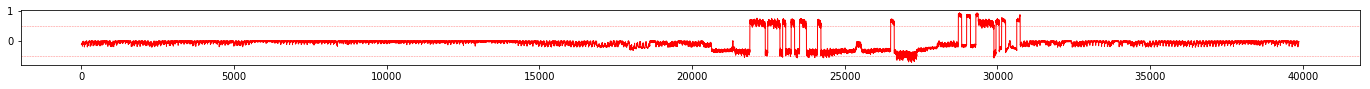

In [17]:
history = model.fit(combo_in, combo_out,
          epochs=20,
          batch_size=batch_size,
          verbose=2,
          validation_data=(val_inputs, val_cat_out),
          sample_weight=combo_sample_weights,
          callbacks=[reduce_lr, graph_cb])

# Evaluate model

dict_keys(['val_loss', 'loss', 'lr'])


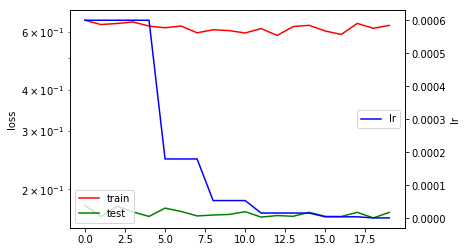

In [18]:
print(history.history.keys())
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_yscale('log')
ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='g')
ax1.set_ylabel('loss')
ax1.legend(['train', 'test'], loc='lower left')
ax2.plot(history.history['lr'], color='b')
ax2.set_ylabel('lr')
ax2.legend(['lr'], loc='center right')
plt.xlabel('epoch')
plt.show()

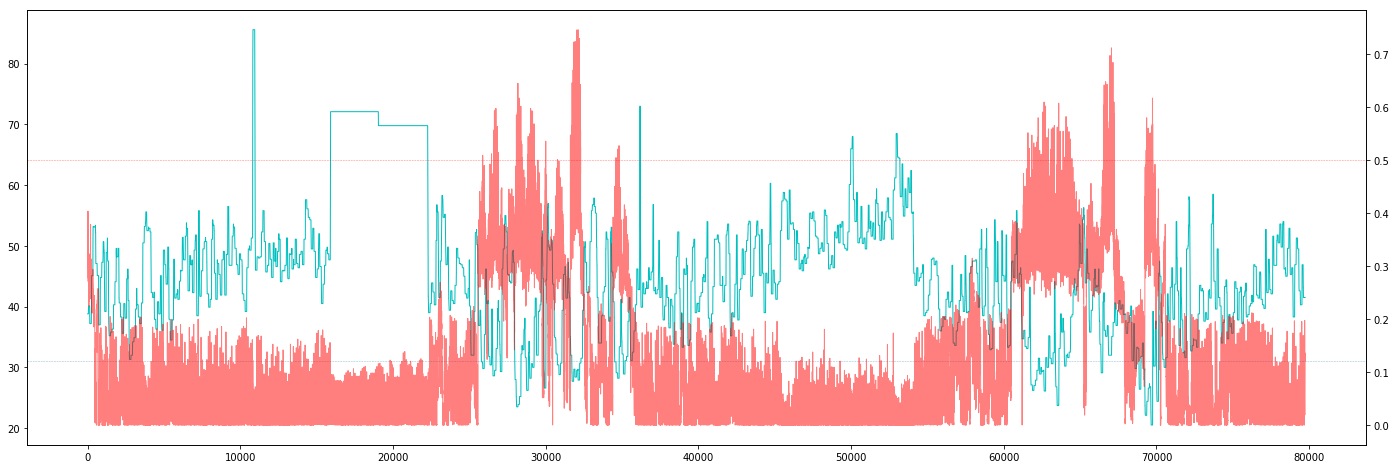

In [19]:
fig, ax1 = plt.subplots(figsize=(24,8))
ax2 = ax1.twinx()

ax1.axhline(31, ls='dashed', lw=0.5, alpha=0.5)
ax2.axhline(0.5, color='r', ls='dashed', lw=0.5, alpha=0.5)
# ax2.axhline(-0.5, color='r', ls='dashed', lw=0.5, alpha=0.5)

# ax1.plot(validation_data.TemperatureF.as_matrix(), 'g', lw=1)
ax2.plot(model.predict(combo_in, batch_size=batch_size).reshape(-1,1), 'r', lw=1, alpha=0.5)

ax1.plot(data.forward_min.as_matrix(), 'c', lw=1)
plt.show()

In [20]:
prediction_data = validation_data.assign(prediction = model.predict(val_inputs, batch_size=batch_size).reshape(-1,1))
prediction_data.index = prediction_data.index.tz_convert('UTC')
prediction_data = prediction_data.assign(fn = (prediction_data.forward_min<=31).astype(int) * (prediction_data.prediction>31).astype(int))
prediction_data = prediction_data.assign(fp = (prediction_data.forward_min>=31).astype(int) * (prediction_data.prediction<31).astype(int))

In [21]:
resample = '12H'
extract = prediction_data.resample('12H').min()
extract.head()

,TemperatureF,DewpointF,PressureIn,WindSpeedMPH,WindSpeedGustMPH,Humidity,HourlyPrecipIn,dailyrainin,SolarRadiationWatts/m^2,forward_min,forecast,prediction,fn,fp
DateUTC,,,,,,,,,,,,,,
2017-04-19 00:00:00+00:00,41.2,41.0,30.16,0.0,0.0,98,0.0,0.0,0.0,39.0,50.0,0.092866,0,1
2017-04-19 12:00:00+00:00,39.0,37.4,30.16,0.0,0.0,39,0.0,0.0,0.0,39.0,46.0,0.011425,0,1
2017-04-20 00:00:00+00:00,40.5,40.3,30.19,0.0,0.0,43,0.0,0.0,0.0,40.5,52.0,0.012898,0,1
2017-04-20 12:00:00+00:00,42.3,41.7,30.20,0.0,0.0,42,0.0,0.0,0.0,39.2,48.0,0.006291,0,1
2017-04-21 00:00:00+00:00,40.6,40.5,30.16,0.0,0.0,48,0.0,0.0,0.0,39.2,47.0,0.001216,0,1


In [ ]:
model.save(model_path+'model.h5')